## Data

This dataset was originally posted on Kaggle. **The key task is to predict whether a product/part will go on backorder.**

Product backorder may be the result of strong sales performance (e.g. the product is in such a high demand that production cannot keep up with sales). However, backorders can upset consumers, lead to canceled orders and decreased customer loyalty. Companies want to avoid backorders, but also avoid overstocking every product (leading to higher inventory costs).

This dataset has ~1.9 million observations of products/parts in an 8 week period. The source of the data is unreferenced.

* __Outcome__: whether the product went on backorder
* __Predictors__: Current inventory, sales history, forecasted sales, recommended stocking amount, product risk flags etc. (22 predictors in total)

The features and the target variable of the dataset are as follows:

**Description**
~~~
# Features: 
sku - Random ID for the product
national_inv - Current inventory level for the part
lead_time - Transit time for product (if available)
in_transit_qty - Amount of product in transit from source
forecast_3_month - Forecast sales for the next 3 months
forecast_6_month - Forecast sales for the next 6 months
forecast_9_month - Forecast sales for the next 9 months
sales_1_month - Sales quantity for the prior 1 month time period
sales_3_month - Sales quantity for the prior 3 month time period
sales_6_month - Sales quantity for the prior 6 month time period
sales_9_month - Sales quantity for the prior 9 month time period
min_bank - Minimum recommend amount to stock
potential_issue - Source issue for part identified
pieces_past_due - Parts overdue from source
perf_6_month_avg - Source performance for prior 6 month period
perf_12_month_avg - Source performance for prior 12 month period
local_bo_qty - Amount of stock orders overdue
deck_risk - Part risk flag
oe_constraint - Part risk flag
ppap_risk - Part risk flag
stop_auto_buy - Part risk flag
rev_stop - Part risk flag

# Target 
went_on_backorder - Product actually went on backorder
~~~

Two data files are given and the files are accessible in the JupyterHub environment:
 * `/dsa/data/all_datasets/back_order/Kaggle_Training_Dataset_v2.csv`
 * `/dsa/data/all_datasets/back_order/Kaggle_Test_Dataset_v2.csv`


 
<span style='background:yellow'>**NOTE:** The training data file is 117MB. **Do NOT try to version control any data files** (training, test, or created), you may blow-through the _push limit_.</span>  
You can easily lock up a notebook with bad coding practices.  
Please save you project early, and often, and use `git commit` to checkpoint your process.



--- 
##  Overview / Roadmap

**General steps**:
* Part I: Preprocessing
  * Dataset carpentry & Exploratory Data Analysis
    * Develop functions to perform the necessary steps, you will have to carpentry the Training and the Testing data.
  * Generate a **smart sample** of the the data
* Part II: Training and Validation
  * Create 3 alternative pipelines, each does:
      * Anomaly detection
      * Dimensionality reduction
      * Classification
* Part III: Testing
  * Train chosen model full training data
  * Evaluate model against testing
  * Write a summary of your processing and an analysis of the model performance




---

# Part I: Data Preprocessing

In this part, we preprocess the given training set. 


In [ ]:
%matplotlib inline
#import matplotlib.pyplot as plt
import os, sys
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

## Load dataset

**Description**
~~~
sku - Random ID for the product
national_inv - Current inventory level for the part
lead_time - Transit time for product (if available)
in_transit_qty - Amount of product in transit from source
forecast_3_month - Forecast sales for the next 3 months
forecast_6_month - Forecast sales for the next 6 months
forecast_9_month - Forecast sales for the next 9 months
sales_1_month - Sales quantity for the prior 1 month time period
sales_3_month - Sales quantity for the prior 3 month time period
sales_6_month - Sales quantity for the prior 6 month time period
sales_9_month - Sales quantity for the prior 9 month time period
min_bank - Minimum recommend amount to stock
potential_issue - Source issue for part identified
pieces_past_due - Parts overdue from source
perf_6_month_avg - Source performance for prior 6 month period
perf_12_month_avg - Source performance for prior 12 month period
local_bo_qty - Amount of stock orders overdue
deck_risk - Part risk flag
oe_constraint - Part risk flag
ppap_risk - Part risk flag
stop_auto_buy - Part risk flag
rev_stop - Part risk flag
went_on_backorder - Product actually went on backorder. 
~~~

**Note**: This is a real-world dataset without any preprocessing.  
There will also be warnings due to fact that the 1st column is mixing integer and string values.  
**NOTE:** The last column, `went_on_backorder`, is what we are trying to predict.


In [2]:
# Dataset location
DATASET = '/dsa/data/all_datasets/back_order/Kaggle_Training_Dataset_v2.csv'
assert os.path.exists(DATASET)

# Load and shuffle
dataset = pd.read_csv(DATASET).sample(frac = 1).reset_index(drop=True)

dataset.head().transpose()


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4
sku,1144790,1872634,1753001,1666766,2097748
national_inv,11.0,4.0,6.0,3.0,6.0
lead_time,12.0,4.0,8.0,8.0,12.0
in_transit_qty,0.0,0.0,0.0,0.0,0.0
forecast_3_month,0.0,0.0,0.0,0.0,62.0
forecast_6_month,0.0,0.0,0.0,0.0,112.0
forecast_9_month,0.0,0.0,0.0,0.0,160.0
sales_1_month,2.0,0.0,0.0,0.0,13.0
sales_3_month,3.0,0.0,1.0,0.0,50.0
sales_6_month,4.0,0.0,2.0,0.0,106.0


In [3]:
dataset.tail

<bound method NDFrame.tail of              sku  national_inv  lead_time  in_transit_qty  forecast_3_month  \
0        1144790          11.0       12.0             0.0               0.0   
1        1872634           4.0        4.0             0.0               0.0   
2        1753001           6.0        8.0             0.0               0.0   
3        1666766           3.0        8.0             0.0               0.0   
4        2097748           6.0       12.0             0.0              62.0   
...          ...           ...        ...             ...               ...   
1687856  1447016           5.0        NaN             0.0               0.0   
1687857  2920568         111.0        8.0             0.0               0.0   
1687858  2184794          10.0        8.0             0.0               0.0   
1687859  2997946          46.0       12.0             0.0               0.0   
1687860  2822140           8.0        8.0             0.0              15.0   

         forecast_6_m

In [4]:
dataset.shape

(1687861, 23)

In [5]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
national_inv,1687860.0,496.111782,29615.233831,-27256.0,4.00,15.00,80.00,12334404.0
lead_time,1586967.0,7.872267,7.056024,0.0,4.00,8.00,9.00,52.0
in_transit_qty,1687860.0,44.052022,1342.741731,0.0,0.00,0.00,0.00,489408.0
forecast_3_month,1687860.0,178.119284,5026.553102,0.0,0.00,0.00,4.00,1427612.0
forecast_6_month,1687860.0,344.986664,9795.151861,0.0,0.00,0.00,12.00,2461360.0
forecast_9_month,1687860.0,506.364431,14378.923562,0.0,0.00,0.00,20.00,3777304.0
sales_1_month,1687860.0,55.926069,1928.195879,0.0,0.00,0.00,4.00,741774.0
sales_3_month,1687860.0,175.025930,5192.377625,0.0,0.00,1.00,15.00,1105478.0
sales_6_month,1687860.0,341.728839,9613.167104,0.0,0.00,2.00,31.00,2146625.0
sales_9_month,1687860.0,525.269701,14838.613523,0.0,0.00,4.00,47.00,3205172.0


## Processing

In this section, the goal is to figure out:

* which columns we can use directly,  
* which columns are usable after some processing,  
* and which columns are not processable or obviously irrelevant (like product id) that we will discard.

Then process and prepare this dataset for creating a predictive model.

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n

In [7]:
dataset.loc[:,'went_on_backorder'].value_counts()

No     1676567
Yes      11293
Name: went_on_backorder, dtype: int64

### Take samples and examine the dataset

In [8]:
dataset.iloc[:3,:6]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month
0,1144790,11.0,12.0,0.0,0.0,0.0
1,1872634,4.0,4.0,0.0,0.0,0.0
2,1753001,6.0,8.0,0.0,0.0,0.0


In [9]:
dataset.iloc[:3,6:12]

,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank
0,0.0,2.0,3.0,4.0,12.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,2.0,3.0,0.0


In [10]:
dataset.iloc[:3,12:18]

,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk
0,No,0.0,0.47,0.39,0.0,No
1,No,0.0,0.73,0.78,0.0,No
2,No,0.0,0.85,0.89,0.0,No


In [11]:
dataset.iloc[:3,18:24]

,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,No,No,Yes,No,No
1,No,No,Yes,No,No
2,No,No,Yes,No,No


### Drop columns that are obviously irrelevant or not processable

In [12]:
# Add code below this comment  (Question #E101)
# ----------------------------------

#Removing the random id column
dataset.drop('sku', axis=1, inplace=True)


In [13]:
#checking for the null values
dataset.isnull().sum()


national_inv              1
lead_time            100894
in_transit_qty            1
forecast_3_month          1
forecast_6_month          1
forecast_9_month          1
sales_1_month             1
sales_3_month             1
sales_6_month             1
sales_9_month             1
min_bank                  1
potential_issue           1
pieces_past_due           1
perf_6_month_avg          1
perf_12_month_avg         1
local_bo_qty              1
deck_risk                 1
oe_constraint             1
ppap_risk                 1
stop_auto_buy             1
rev_stop                  1
went_on_backorder         1
dtype: int64

In [14]:
dataset.loc[:,'lead_time'].isnull().value_counts()

False    1586967
True      100894
Name: lead_time, dtype: int64

In [15]:
dataset.loc[:,'lead_time'].value_counts()

8.0     682186
2.0     337402
12.0    199700
4.0     128537
9.0     123649
52.0     30113
3.0      16253
10.0     14192
0.0      10511
14.0     10314
16.0      8843
13.0      5405
6.0       5365
5.0       4031
15.0      3812
17.0      3763
11.0      1094
20.0       416
30.0       312
18.0       221
7.0        209
22.0       133
24.0       115
26.0       105
28.0        84
21.0        49
40.0        48
35.0        35
19.0        28
1.0         21
23.0        14
25.0         7
Name: lead_time, dtype: int64

In [16]:
dataset['lead_time'].fillna(dataset['lead_time'].mode()[0], inplace=True)
dataset.isnull().sum()


national_inv         1
lead_time            0
in_transit_qty       1
forecast_3_month     1
forecast_6_month     1
forecast_9_month     1
sales_1_month        1
sales_3_month        1
sales_6_month        1
sales_9_month        1
min_bank             1
potential_issue      1
pieces_past_due      1
perf_6_month_avg     1
perf_12_month_avg    1
local_bo_qty         1
deck_risk            1
oe_constraint        1
ppap_risk            1
stop_auto_buy        1
rev_stop             1
went_on_backorder    1
dtype: int64

In [17]:
dataset = dataset.dropna()
dataset.isnull().sum()

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64

### Find unique values of string columns

Now try to make sure that these Yes/No columns really only contains Yes or No.  
If that's true, proceed to convert them into binaries (0s and 1s).

**Tip**: use [unique()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.unique.html) function of pandas Series.

Example

~~~python
print('went_on_backorder', dataset['went_on_backorder'].unique())
~~~

In [18]:
# All the column names of these yes/no columns
yes_no_columns = list(filter(lambda i: dataset[i].dtype!=np.float64, dataset.columns))
print(yes_no_columns)

# Add code below this comment  (Question #E102)
# ----------------------------------
print("potential_issue:", dataset.potential_issue.unique())
print("deck_risk:", dataset.deck_risk.unique())
print("oe_constraint", dataset.oe_constraint.unique())
print("ppap_risk", dataset.ppap_risk.unique())
print("stop_auto_buy", dataset.stop_auto_buy.unique())
print("rev_stop", dataset.rev_stop.unique())
print('went_on_backorder', dataset['went_on_backorder'].unique())


['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']
potential_issue: ['No' 'Yes']
deck_risk: ['No' 'Yes']
oe_constraint ['No' 'Yes']
ppap_risk ['No' 'Yes']
stop_auto_buy ['Yes' 'No']
rev_stop ['No' 'Yes']
went_on_backorder ['No' 'Yes']


You may see **nan** also as possible values representing missing values in the dataset.

We fill them using most popular values, the [Mode](https://en.wikipedia.org/wiki/Mode_%28statistics%29) in Stats.

In [19]:
for column_name in yes_no_columns:
    mode = dataset[column_name].apply(str).mode()[0]
    print('Filling missing values of {} with {}'.format(column_name, mode))
    dataset[column_name].fillna(mode, inplace=True)

Filling missing values of potential_issue with No


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Filling missing values of deck_risk with No
Filling missing values of oe_constraint with No
Filling missing values of ppap_risk with No
Filling missing values of stop_auto_buy with Yes
Filling missing values of rev_stop with No
Filling missing values of went_on_backorder with No


### Convert yes/no columns into binary (0s and 1s)

In [52]:
# Add code below this comment  (Question #E103)
# ----------------------------------
cat = dataset.select_dtypes(include = ['object']).columns
for col in cat:
    dataset[col].replace({'No': 0, 'Yes': 1}, inplace=True)
    dataset[col] = dataset[col].astype(int)

In [53]:
print("potential_issue:", dataset.potential_issue.unique())
print("deck_risk:", dataset.deck_risk.unique())
print("oe_constraint", dataset.oe_constraint.unique())
print("ppap_risk", dataset.ppap_risk.unique())
print("stop_auto_buy", dataset.stop_auto_buy.unique())
print("rev_stop", dataset.rev_stop.unique())
print('went_on_backorder', dataset['went_on_backorder'].unique())

potential_issue: [0 1]
deck_risk: [0 1]
oe_constraint [0 1]
ppap_risk [0 1]
stop_auto_buy [1 0]
rev_stop [0 1]
went_on_backorder [0 1]


Now all columns should be either int64 or float64.

In [22]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687860 entries, 0 to 1687860
Data columns (total 22 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   national_inv       1687860 non-null  float64
 1   lead_time          1687860 non-null  float64
 2   in_transit_qty     1687860 non-null  float64
 3   forecast_3_month   1687860 non-null  float64
 4   forecast_6_month   1687860 non-null  float64
 5   forecast_9_month   1687860 non-null  float64
 6   sales_1_month      1687860 non-null  float64
 7   sales_3_month      1687860 non-null  float64
 8   sales_6_month      1687860 non-null  float64
 9   sales_9_month      1687860 non-null  float64
 10  min_bank           1687860 non-null  float64
 11  potential_issue    1687860 non-null  int64  
 12  pieces_past_due    1687860 non-null  float64
 13  perf_6_month_avg   1687860 non-null  float64
 14  perf_12_month_avg  1687860 non-null  float64
 15  local_bo_qty       1687860 non-n

# Exploratory Data Analysis

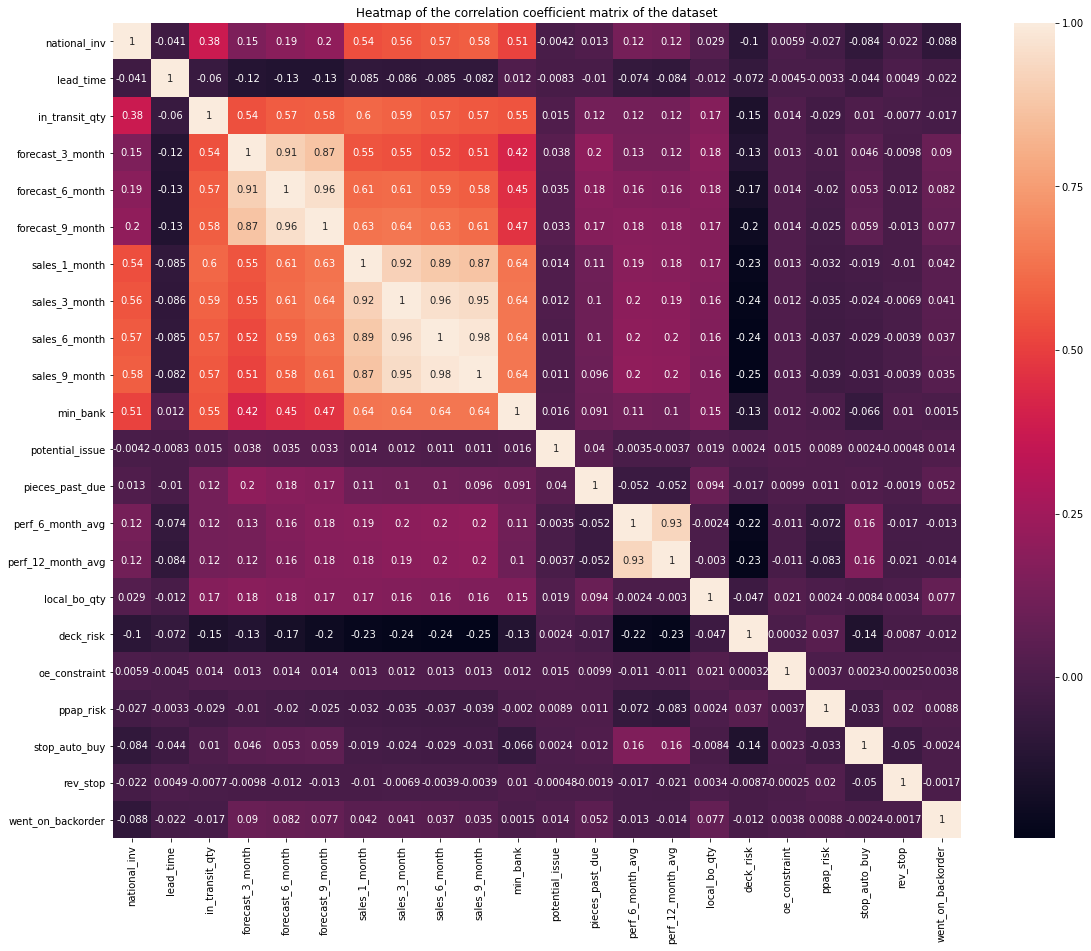

In [23]:
import seaborn as sns
plt.figure(figsize=(19,15))
sns.heatmap(dataset.corr(method='spearman'), annot=True)
plt.title('Heatmap of the correlation coefficient matrix of the dataset')
plt.show()

<AxesSubplot:ylabel='Frequency'>

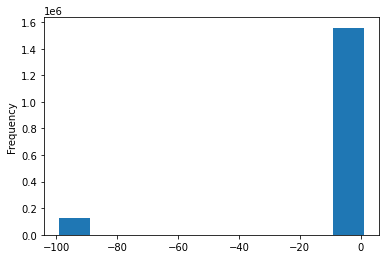

In [24]:
dataset.perf_6_month_avg.plot.hist()

<AxesSubplot:ylabel='Frequency'>

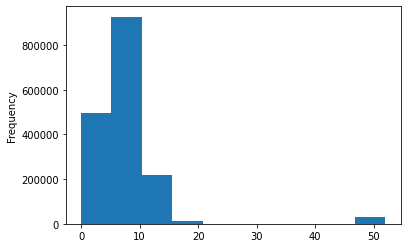

In [25]:
dataset.lead_time.plot.hist()

<AxesSubplot:ylabel='Frequency'>

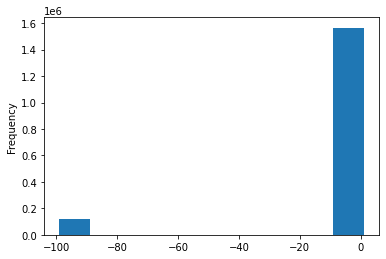

In [26]:
dataset.perf_12_month_avg.plot.hist()

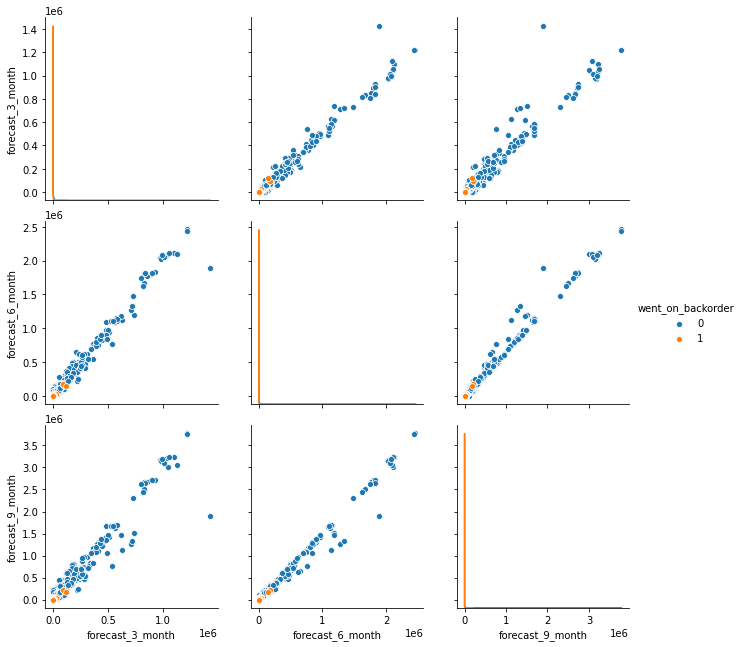

In [36]:
# Forecast columns
forecasts = ['forecast_3_month','forecast_6_month', 'forecast_9_month']

# Pair-wise scatter plot for the forecasts
sns.pairplot(dataset, vars=forecasts, hue='went_on_backorder', height=3)

# Show the plot
plt.show()

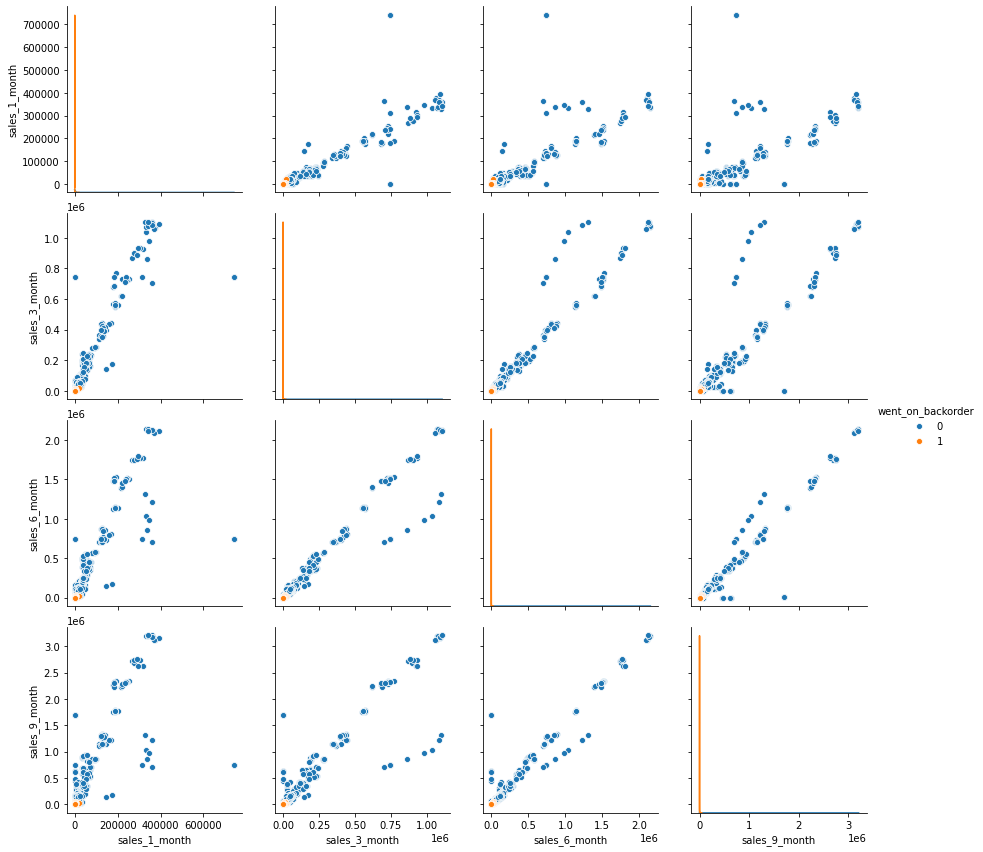

In [39]:
# Do a pair-wise scatter plot for sales
sales = ['sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month']
sns.pairplot(dataset, vars=sales, hue='went_on_backorder', height=3)
plt.show()

The sales have good linear correlations with each other, as expected from the correlation matrix. There are some instances when the sales at different time frames fall away from the linear correlation. Backorders only occur when sales are low.

### Smartly sample the data into a more manageable size for cross-fold validation in Grid Search

**Note**: This is a good point to re-balance dataset before actually moving on. For sampling we can either take advantage of pandas/numpy `sample` method or use `imblearn` [package](https://imbalanced-learn.org/stable/user_guide.html#user-guide). 

`imblearn` module has implemented a pipeline on top sklearn pipeline, and it is possible to add sampling strategies within the `imblearn` pipeline. We are not required to use `imblearn` pipeline for this project. 

In [28]:
num_backorder = np.sum(dataset['went_on_backorder']==1)
print('backorder ratio:', num_backorder, '/', len(dataset), '=', num_backorder / len(dataset))

backorder ratio: 11293 / 1687860 = 0.006690720794378681


Create a smart sample of the dataset. You can either store the data to csv files or simply use `joblib` to dump the variables and load them in Part 2. 

**Example code for using joblib:**

Say we need to store three objects (sampled_X, sampled_y, model) to a file. 

```python
import joblib

# for dumping 
joblib.dump([sampled_X, sampled_y, model], 'data/sample-data-v1.pkl')

# for loading
sampled_X, sampled_y, model = joblib.load('data/sample-data-v1.pkl')

```


# Data Sampling

In [29]:
dataset.loc[:,'went_on_backorder'].value_counts()

0    1676567
1      11293
Name: went_on_backorder, dtype: int64

In [30]:
# Add code below this comment   (Question #E104) 
# -------------------------------
#Downsampling the dataset as the number of samples in the class having less number of samples.

dataset_not_wentonbackorder = dataset[dataset.went_on_backorder==0]
dataset_wentonbackorder = dataset[dataset.went_on_backorder==1]


In [31]:
from sklearn.utils import resample
not_wentbackorder_downsampled=resample(dataset_not_wentonbackorder,
                                replace = False, # sample without replacement
                                n_samples = dataset_wentonbackorder.shape[0], # match minority n
                                random_state = 27) 

dataset_downsampled = pd.concat([dataset_wentonbackorder,not_wentbackorder_downsampled])

# check new class counts
dataset_downsampled.went_on_backorder.value_counts()

0    11293
1    11293
Name: went_on_backorder, dtype: int64

In [32]:
dataset_downsampled.shape

(22586, 22)


**Note:** After sampling the data, you may want to write the data to a file for reloading later.

<span style="background: yellow;">If required, remove the `dataset` variable to avoid any memory-related issue.</span> 

In [33]:
# Write your smart sampling to local file  
# ----------------------------------
import joblib
joblib.dump(dataset_downsampled, 'preprocessed_data_part1.pkl')

['preprocessed_data_part1.pkl']

You should have made a couple commits so far of this project.  
**Definitely make a commit of the notebook now!**  
Comment should be: `Final Project, Checkpoint - Data Sampled`


# Save your notebook!
## Then `File > Close and Halt`